In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import time
import math
import copy
import random
from matplotlib import pyplot as plt
import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
data = pd.read_csv("./data_banknote_authentication.txt", header=None)
m, n = data.shape
# seperate into input and output features
X, Y = data.values[:, :-1], data.values[:, -1]
Y = LabelEncoder().fit_transform(Y)
# split into train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train = X_train.T
X_test = X_test.T

In [7]:
def relu(Z):
    return np.maximum(Z, 0)

def tanh(Z):
    return np.tanh(Z)

def sigmoid(Z):
    # prevent exp overflow arning does not affect calculation as it becomes 0
    np.warnings.filterwarnings('ignore', 'overflow')
    return 1/(1+np.exp(-Z))

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def relu_deriv(Z):
    return Z > 0

def tanh_deriv(Z):
    return 1-np.tanh(Z)**2

def sigmoid_deriv(Z):
    sig = 1/(1+np.exp(-Z))
    return sig * (1 - sig)

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

In [8]:
class NeuralNetwork:
    def __init__(self, layer_sizes, epochs, alpha, activations):
            self.layer_sizes = layer_sizes
            self.num_iters = epochs
            self.learning_rate = alpha
            self.activations = activations
            self.params = {}
            self.last = len(self.layer_sizes)
            self.init_params()
            self.accuracy = None
            self.X = None
            self.Y = None
            self.AccuracyList = []
            self.AccuracyEpochList = []
            self.AccuracyTimeList = []
            self.totalTime = None
            self.startTime = None
            self.stopTime = None
            
    def __repr__(self):
        return f"ANN Hyperparameters\nLayers: {self.layer_sizes}\nIterations: {self.num_iters} \
                \nLearning rate: {self.learning_rate}\nActivations: {self.activations}"
    
    # Initalize the network with random weights and biases
    def init_params(self):
        # Initalize the network with random weights and biases 
        params = self.params
        for i in range(1, self.last):
            params[f'W{i}'] = np.random.rand(self.layer_sizes[i], self.layer_sizes[i-1]) - 0.5
            params[f'B{i}'] = np.random.rand(self.layer_sizes[i],1) - 0.5

    def forward_propagation(self, X):
        # Pass X through the network 
        params = self.params
        for i in range(1, self.last):
            if i==1:
                # For first layer compute dot with x
                output = params[f'W{i}'].dot(X) + params[f'B{i}']
            else: 
                # For all other layers compute with output of prev layer
                output = params[f'W{i}'].dot(params[f'A{i-1}']) + params[f'B{i}']
          
            # For all other layers use the activ_fnc initalized in constructor
            activ_fnc = self.activations[i-1]
            activations = globals()[activ_fnc](output)
            
            params[f'Z{i}'] = output
            params[f'A{i}'] = activations


    def backward_propagation(self, X, Y):
        ohY = one_hot(Y)
        params = self.params
        
        for i in range(self.last - 1, 0, -1):
            if(i == self.last - 1):
                # For final layer calculate how wrong net is and compute gradients for weights and biases
                dZ =  params[f'A{i}'] - ohY
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(params[f'A{i-1}'].T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)
            elif (i == 1):
                # For first layer compute the gradients for weights and biases with input of dataset
                dZ = params[f'W{i+1}'].T.dot(params[f'dZ{i+1}']) * globals()[f'{self.activations[i-1]}_deriv'](params[f'Z{i}'])
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(X.T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)
            else: 
                # For all other layers compute the gradients for weights and biases with the output of the prev layer
                dZ = params[f'W{i+1}'].T.dot(params[f'dZ{i+1}']) * globals()[f'{self.activations[i-1]}_deriv'](params[f'Z{i}'])
                params[f'dZ{i}'] = dZ
                params[f'dW{i}'] = 1 / m * dZ.dot(params[f'A{i-1}'].T)
                params[f'dB{i}'] = 1 / m * np.sum(dZ)

    
    def update_params(self, alpha):
        # Update all layers based on the gradients calculated in back prop
        params = self.params
        for i in range(1, self.last):
            params[f'W{i}'] =  params[f'W{i}'] - self.learning_rate * params[f'dW{i}']
            params[f'B{i}'] =  params[f'B{i}'] - self.learning_rate * params[f'dB{i}']

    def make_preds(self, X):
        self.forward_propagation(X)
        predictions = self.get_preds()
        return predictions

    def test_preds(self, i):
        curr = X_train[:, i, None]
        print("label ", Y_train[i])
        print("predicted ", self.make_preds(curr)[0])

    def get_preds(self):
        return np.argmax(self.params[f'A{self.last-1}'], 0)

    def get_accuracy(self, predictions, Y):
        return np.sum(predictions == Y) / Y.size
    
    def train(self, X, Y, printAccuracy=False):
        start = time.perf_counter()
        self.X = X
        self.Y = Y
        for i in range(self.num_iters):
            self.forward_propagation(X)
            self.backward_propagation(X, Y)
            self.update_params(self.learning_rate)
       
            predictions = self.get_preds()
            self.accuracy = self.get_accuracy(predictions, Y)
            self.AccuracyList.append(self.accuracy)
            self.AccuracyEpochList.append((i,self.accuracy))
            self.AccuracyTimeList.append(((time.perf_counter() - start), self.accuracy))
       
            # Print accuracy every 10 iterations
            if(printAccuracy==True):
                if i % 1 == 0:
                    print("Iteration: ", i)
                    print('Accuracy: ', self.accuracy)
        stop = time.perf_counter()
        self.totalTime = stop - start
        self.startTime = start
        self.stopTime = stop
        return self.params
     
    def change_neurons(self, layers, printChange=True, showIteration=False):
        old_accuracy = self.accuracy
        self.layer_sizes = layers
        self.init_params()
        self.train(self.X, self.Y, showIteration)
        if (printChange==True):
            print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")    

    def change_activations(self, activations, printChange=False, showIteration=False):
        old_accuracy = self.accuracy
        self.activations = activations
        self.init_params()
        self.train(self.X, self.Y, showIteration)
        if (printChange==True):
            print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")

    def change_epochs(self, epochs, printChange=True, showIteration=False):
        old_accuracy = self.accuracy
        self.num_iters = epochs
        self.init_params()
        self.train(self.X, self.Y, showIteration)
        if (printChange==True):
            print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")
    
    def change_learningRate(self, alpha, printChange=True, showIteration=False):
        old_accuracy = self.accuracy
        self.learning_rate = alpha
        self.init_params()
        self.train(self.X, self.Y, showIteration)
        if (printChange==True):
            print(f"Old test accuracy: {old_accuracy}\nNew test accuracy: {self.accuracy}")
        
    def view_accuracyEpoch(self):
        sns.set(rc={'figure.figsize':(15,8)})
        df = pd.DataFrame(self.AccuracyEpochList, columns=["Epochs", "Accuracy"])
        sns.lineplot(data=df, x="Epochs", y="Accuracy", ci=None)
    
    def view_accuracyTime(self):
        sns.set(rc={'figure.figsize':(15,8)})
        df = pd.DataFrame(self.AccuracyTimeList, columns=["Time", "Accuracy"])
        sns.lineplot(data=df, x="Time", y="Accuracy", ci=None)

In [9]:
nn = NeuralNetwork([4,10,10,2], 500, 0.10, ['relu','relu','sigmoid'])

In [10]:
x = nn.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.44479166666666664
Iteration:  1
Accuracy:  0.44479166666666664
Iteration:  2
Accuracy:  0.44479166666666664
Iteration:  3
Accuracy:  0.44479166666666664
Iteration:  4
Accuracy:  0.44479166666666664
Iteration:  5
Accuracy:  0.44479166666666664
Iteration:  6
Accuracy:  0.44479166666666664
Iteration:  7
Accuracy:  0.44479166666666664
Iteration:  8
Accuracy:  0.44479166666666664
Iteration:  9
Accuracy:  0.44479166666666664
Iteration:  10
Accuracy:  0.44479166666666664
Iteration:  11
Accuracy:  0.44479166666666664
Iteration:  12
Accuracy:  0.44583333333333336
Iteration:  13
Accuracy:  0.4479166666666667
Iteration:  14
Accuracy:  0.4583333333333333
Iteration:  15
Accuracy:  0.475
Iteration:  16
Accuracy:  0.490625
Iteration:  17
Accuracy:  0.515625
Iteration:  18
Accuracy:  0.5489583333333333
Iteration:  19
Accuracy:  0.5833333333333334
Iteration:  20
Accuracy:  0.6114583333333333
Iteration:  21
Accuracy:  0.6447916666666667
Iteration:  22
Accuracy:  0.692708333333

In [11]:
preds = nn.make_preds(X_test)

In [12]:
nn.test_preds(1)

label  1
predicted  1


In [13]:
nn.test_preds(2)

label  0
predicted  0


## Hyperparameter Investigation

#### Informal Investigation

In [14]:
def compareThrice(nn, parameter, new_values):
        one = copy.deepcopy(nn)
        #one.train(nn.X, nn.Y)
    
        two = copy.deepcopy(nn)
        #two.train(nn.X, nn.Y)
        
        three = copy.deepcopy(nn)
        #three.train(nn.X, nn.Y)
        
        new_accuracy = None
        
        if (parameter == "neurons"):
            one.change_neurons(new_values[0], printChange=False)
            one.train(nn.X, nn.Y, printAccuracy=False)
            
            two.change_neurons(new_values[1], printChange=False)
            two.train(nn.X, nn.Y, printAccuracy=False)
            
            three.change_neurons(new_values[2], printChange=False)
            three.train(nn.X, nn.Y, printAccuracy=False)
            
            new_accuracy = np.mean([one.accuracy,two.accuracy,three.accuracy])
        
        elif(parameter == "activations"):
            one.change_activations(new_values[0], printChange=False)
            one.train(nn.X, nn.Y, printAccuracy=False)
            
            two.change_activations(new_values[1], printChange=False)
            two.train(nn.X, nn.Y, printAccuracy=False)
            
            three.change_activations(new_values[2], printChange=False)
            three.train(nn.X, nn.Y, printAccuracy=False)
            
            new_accuracy = np.mean([one.accuracy,two.accuracy,three.accuracy])
        
        elif(parameter == "epochs"):
            one.change_epochs(new_values[0], printChange=False)
            one.train(nn.X, nn.Y, printAccuracy=False)
            
            two.change_epochs(new_values[1], printChange=False)
            two.train(nn.X, nn.Y, printAccuracy=False)
            
            three.change_epochs(new_values[2], printChange=False)
            three.train(nn.X, nn.Y, printAccuracy=False)
            
            new_accuracy = np.mean([one.accuracy,two.accuracy,three.accuracy])
        
        elif(parameter == "learningRate"):
            one.change_learningRate(new_values[0], printChange=False)
            one.train(nn.X, nn.Y, printAccuracy=False)
            
            two.change_learningRate(new_values[1], printChange=False)
            two.train(nn.X, nn.Y, printAccuracy=False)
            
            three.change_learningRate(new_values[2], printChange=False)
            three.train(nn.X, nn.Y, printAccuracy=False)
            
            new_accuracy = np.mean([one.accuracy,two.accuracy,three.accuracy])
        
        else:
            print("Error comparing") 
        
        print(f"Original accuracy: {nn.accuracy}\nMean accuracy from three trials of different {parameter}: {new_accuracy}")

In [73]:
ann = NeuralNetwork([4,5,5,2], 100, 1, ['relu','relu','sigmoid'])

In [74]:
ann.train(X_train, Y_train, printAccuracy=False);

In [75]:
# Original Hyperparameters
ann

ANN Hyperparameters
Layers: [4, 5, 5, 2]
Iterations: 100                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

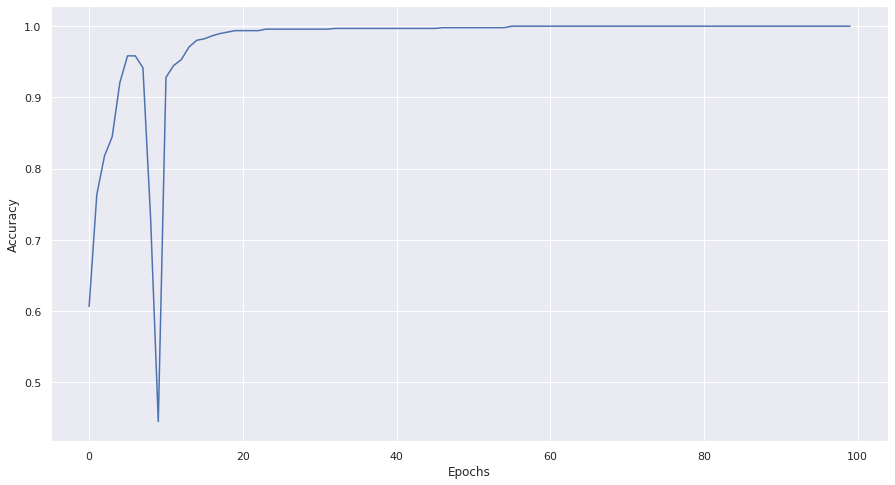

In [64]:
ann.view_accuracyEpoch()

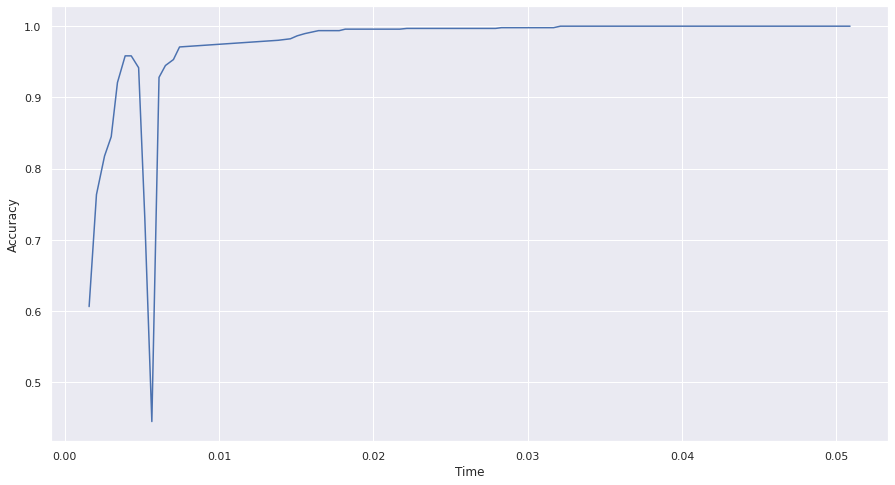

In [65]:
ann.view_accuracyTime()

In [76]:
ann

ANN Hyperparameters
Layers: [4, 5, 5, 2]
Iterations: 100                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

In [77]:
# large number of layers

manyLayers = copy.deepcopy(ann)
manyLayers.change_neurons([4,8,8,2])

Old test accuracy: 0.44479166666666664
New test accuracy: 0.9958333333333333


In [78]:
# Change activation functions
annActs = copy.deepcopy(ann)
annActs.change_activations(['sigmoid', 'sigmoid','sigmoid'])

In [79]:
# Current Hyperparameters
annActs

ANN Hyperparameters
Layers: [4, 5, 5, 2]
Iterations: 100                 
Learning rate: 1
Activations: ['sigmoid', 'sigmoid', 'sigmoid']

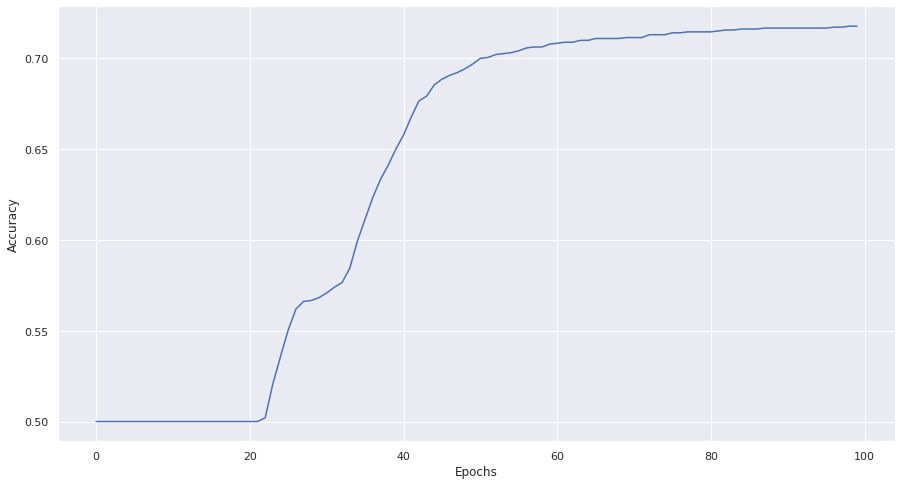

In [80]:
annActs.view_accuracyEpoch()

In [115]:
# Change Number of Iterations
annEpochs = copy.deepcopy(ann)
annEpochs.change_epochs(50)

Old test accuracy: 0.44479166666666664
New test accuracy: 1.0


In [116]:
annEpochs

ANN Hyperparameters
Layers: [4, 5, 5, 2]
Iterations: 50                 
Learning rate: 1
Activations: ['relu', 'relu', 'sigmoid']

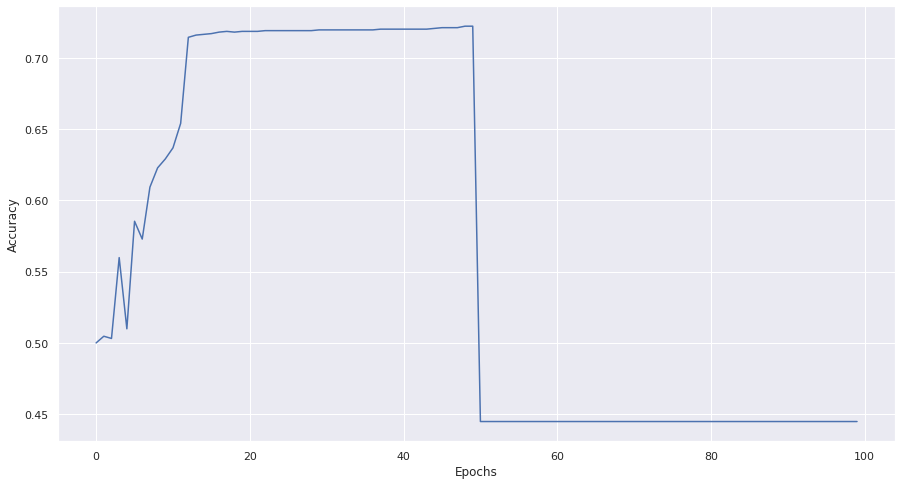

In [117]:
annEpochs.view_accuracyEpoch()

In [121]:
# Change Learning rate
annAlpha = copy.deepcopy(ann)
annAlpha.change_learningRate(0.05)

Old test accuracy: 0.44479166666666664
New test accuracy: 0.890625


In [122]:
annAlpha

ANN Hyperparameters
Layers: [4, 5, 5, 2]
Iterations: 100                 
Learning rate: 0.05
Activations: ['relu', 'relu', 'sigmoid']

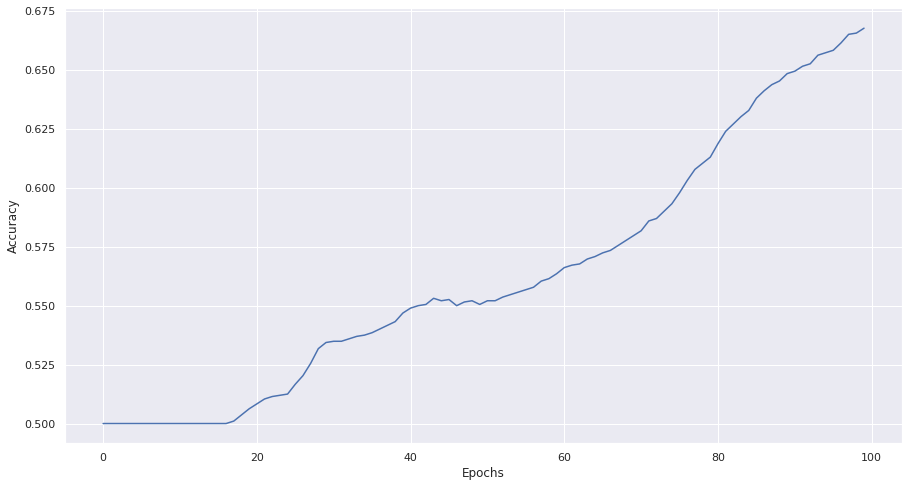

In [123]:
annAlpha.view_accuracyEpoch();

In [129]:
ann_shallow = NeuralNetwork([4,6,6,2], 100, 0.35, ['relu','relu','sigmoid'])

In [130]:
as_output = ann_shallow.train(X_train, Y_train, printAccuracy=False)

In [131]:
ann_deep = NeuralNetwork([4,6,6,6,6,6,6,6,6,2], 100, 0.35, ['relu','relu','relu','relu','relu','relu','relu','relu','sigmoid'])

In [132]:
ad_output = ann_deep.train(X_train, Y_train, printAccuracy=False)

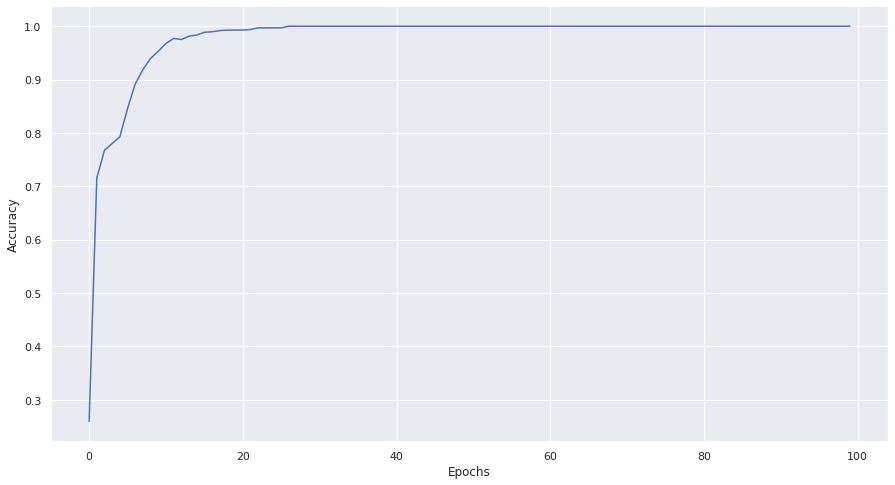

In [35]:
ann_shallow.view_accuracyEpoch();

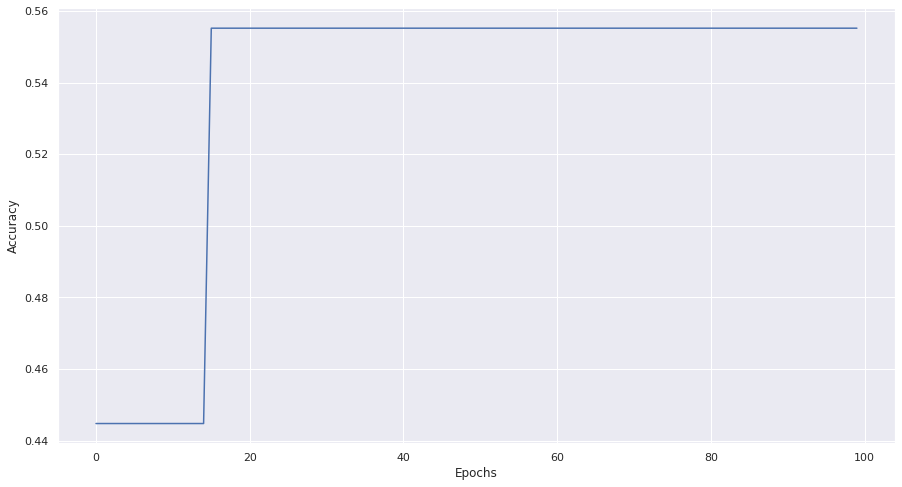

In [133]:
ann_deep.view_accuracyEpoch();

In [37]:
ann_sigmoid = NeuralNetwork([4,6,6,2], 100, 0.35, ['relu','relu','sigmoid'])

In [38]:
sigmoid_output = ann_sigmoid.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.559375
Iteration:  1
Accuracy:  0.7197916666666667
Iteration:  2
Accuracy:  0.7479166666666667
Iteration:  3
Accuracy:  0.7875
Iteration:  4
Accuracy:  0.821875
Iteration:  5
Accuracy:  0.8833333333333333
Iteration:  6
Accuracy:  0.9354166666666667
Iteration:  7
Accuracy:  0.9552083333333333
Iteration:  8
Accuracy:  0.9645833333333333
Iteration:  9
Accuracy:  0.9739583333333334
Iteration:  10
Accuracy:  0.9802083333333333
Iteration:  11
Accuracy:  0.98125
Iteration:  12
Accuracy:  0.98125
Iteration:  13
Accuracy:  0.9822916666666667
Iteration:  14
Accuracy:  0.9833333333333333
Iteration:  15
Accuracy:  0.984375
Iteration:  16
Accuracy:  0.9854166666666667
Iteration:  17
Accuracy:  0.9854166666666667
Iteration:  18
Accuracy:  0.9864583333333333
Iteration:  19
Accuracy:  0.9875
Iteration:  20
Accuracy:  0.9875
Iteration:  21
Accuracy:  0.9895833333333334
Iteration:  22
Accuracy:  0.990625
Iteration:  23
Accuracy:  0.9916666666666667
Iteration:  24
Accuracy:  0.

In [39]:
ann_softmax = NeuralNetwork([4,6,6,2], 100, 0.35, ['relu','relu','softmax'])

In [40]:
softmax_output = ann_softmax.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.45625
Iteration:  1
Accuracy:  0.534375
Iteration:  2
Accuracy:  0.7572916666666667
Iteration:  3
Accuracy:  0.759375
Iteration:  4
Accuracy:  0.76875
Iteration:  5
Accuracy:  0.778125
Iteration:  6
Accuracy:  0.790625
Iteration:  7
Accuracy:  0.8114583333333333
Iteration:  8
Accuracy:  0.825
Iteration:  9
Accuracy:  0.8479166666666667
Iteration:  10
Accuracy:  0.8604166666666667
Iteration:  11
Accuracy:  0.875
Iteration:  12
Accuracy:  0.89375
Iteration:  13
Accuracy:  0.909375
Iteration:  14
Accuracy:  0.921875
Iteration:  15
Accuracy:  0.9354166666666667
Iteration:  16
Accuracy:  0.9489583333333333
Iteration:  17
Accuracy:  0.9635416666666666
Iteration:  18
Accuracy:  0.9802083333333333
Iteration:  19
Accuracy:  0.984375
Iteration:  20
Accuracy:  0.9854166666666667
Iteration:  21
Accuracy:  0.9864583333333333
Iteration:  22
Accuracy:  0.9895833333333334
Iteration:  23
Accuracy:  0.990625
Iteration:  24
Accuracy:  0.9916666666666667
Iteration:  25
Accuracy:

In [41]:
ann_tanh = NeuralNetwork([4,6,6,2], 100, 0.35, ['tanh','tanh','sigmoid'])

In [42]:
tanh_output = ann_tanh.train(X_train, Y_train, printAccuracy=True)

Iteration:  0
Accuracy:  0.44479166666666664
Iteration:  1
Accuracy:  0.5135416666666667
Iteration:  2
Accuracy:  0.5791666666666667
Iteration:  3
Accuracy:  0.6322916666666667
Iteration:  4
Accuracy:  0.6802083333333333
Iteration:  5
Accuracy:  0.7354166666666667
Iteration:  6
Accuracy:  0.7510416666666667
Iteration:  7
Accuracy:  0.775
Iteration:  8
Accuracy:  0.7864583333333334
Iteration:  9
Accuracy:  0.8083333333333333
Iteration:  10
Accuracy:  0.8302083333333333
Iteration:  11
Accuracy:  0.85625
Iteration:  12
Accuracy:  0.8802083333333334
Iteration:  13
Accuracy:  0.9072916666666667
Iteration:  14
Accuracy:  0.9239583333333333
Iteration:  15
Accuracy:  0.9395833333333333
Iteration:  16
Accuracy:  0.95
Iteration:  17
Accuracy:  0.9583333333333334
Iteration:  18
Accuracy:  0.965625
Iteration:  19
Accuracy:  0.971875
Iteration:  20
Accuracy:  0.9770833333333333
Iteration:  21
Accuracy:  0.9770833333333333
Iteration:  22
Accuracy:  0.9791666666666666
Iteration:  23
Accuracy:  0.9833

In [43]:
compareThrice(ann, "neurons", [[4,5,5,2], [4,10,10,2], [4,15,15,2]])

Original accuracy: 0.959375
Mean accuracy from three trials of different neurons: 1.0


In [44]:
compareThrice(ann, "activations", [["relu","relu","relu"], ["relu","tanh","sigmoid"], ["tanh","relu", "sigmoid"]])

Original accuracy: 0.959375
Mean accuracy from three trials of different activations: 1.0


In [45]:
compareThrice(ann, "epochs", [20,40,60])

Original accuracy: 0.959375
Mean accuracy from three trials of different epochs: 0.8506944444444443


In [46]:
compareThrice(ann, "learningRate", [0.1,0.5,0.75])

Original accuracy: 0.959375
Mean accuracy from three trials of different learningRate: 0.9996527777777778


#### Formal

Hyperparameter values are chosen randomly within a range, performance metrics are averaged over 10 runs for each value. 

In [47]:
# trains network 10 times 
def run_ten(nn, X, Y):
    # stores run results in array
    nets = []
    for i in range(10):
        nc = copy.deepcopy(nn)
        # resets parameters every run
        nc.init_params() 
        nc.train(X, Y, printAccuracy=False)
        nets.append(nc)
    return nets

As our ANN reaches 100% accuracy, calulcating mean using the final accuracy would not be insightful as it would produce the same values. Therefore, we had to add another 
measure, which was the mean epoch at which accuracy hit 100%. This informs you which values allow ANN to converge faster. 



In [48]:
# gets mean, standard deviation, mean execution time, standard deviation execution time and number of runs that get stuck at a local minima
# across the 10 runs
def get_converg(nets):
    np_nets = np.array(nets)
    convergFilter = np.array(list(map((lambda n: n.accuracy == np.float64(1)), nets)))

    convergs = list(map((lambda n: np.where(n.AccuracyEpochList==np.float64(1))[0][1]), np_nets[convergFilter]))
    times = list(map((lambda n: np.where(n.AccuracyTimeList==np.float64(1))[0][1]), np_nets[convergFilter]))

    mean_converg = np.mean(convergs)
    std_converg = np.std(convergs)
    mean_times = np.mean(times)
    std_times = np.std(times)
    num_non_conv = len(np_nets) - len(convergFilter[convergFilter])
    
    return mean_converg, std_converg, mean_times, std_times, num_non_conv

In [49]:
# gets mean and standard deviation for accuracy 
def get_metrics(nets):
    accuracies = list(map((lambda x: x.accuracy), nets))
    mean = np.mean(accuracies)
    std = np.std(accuracies)
    return mean, std

In [50]:
test_net = NeuralNetwork([4,10,10,2], 1000, 0.49, ['relu','relu','sigmoid'])

In [51]:
# compares a specifed sample number of randomly selected learning rates within a defined range
def compareLR(nn, X, Y, lower, upper, n_tests):
    test_values = list(map(lambda x: random.uniform(lower, upper), range(n_tests))) 
    results = {}

    i = 1
    for lr in test_values: 
        new_net = NeuralNetwork(nn.layer_sizes, nn.num_iters, lr, nn.activations)
        ten_nets = run_ten(new_net, X_train, Y_train)
        results[lr] = get_converg(ten_nets)
        print('progress', f'{i}/{len(test_values)}')
        i+=1
    # results are sorted ascending based on mean epochs
    sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
    print('Output format: epochs mean (standard deviation), time mean (standard deviation), num runs that did not reach 100% acc')
    for key, value in sorted_by_mean.items():
        print('lr', key, ' : ', 'epochs', round(value[0], 4), f'({round(value[1], 4)})', 'time', round(value[2], 4),  f'({round(value[3], 4)})', 'not 100%:', value[4])        


In [52]:
# comparing randomly chosen learning rates from 0.000001 to 1.0 
compareLR(test_net, X_train, Y_train, 0.000001, 1.0, 11)

progress 1/11
progress 2/11
progress 3/11
progress 4/11
progress 5/11
progress 6/11
progress 7/11
progress 8/11
progress 9/11
progress 10/11
progress 11/11
Output format: epochs mean (standard deviation), time mean (standard deviation), num runs that did not reach 100% acc
lr 0.3758475099371392  :  epochs 36.7 (12.5861) time 37.7 (12.5861) not 100%: 0
lr 0.8456317134871199  :  epochs 36.9 (19.8467) time 37.9 (19.8467) not 100%: 0
lr 0.35633164167335624  :  epochs 41.2 (20.6) time 42.2 (20.6) not 100%: 0
lr 0.3825348789626845  :  epochs 45.1 (22.9061) time 46.1 (22.9061) not 100%: 0
lr 0.5267700005848398  :  epochs 46.6 (55.843) time 47.6 (55.843) not 100%: 0
lr 0.8916626125100312  :  epochs 51.875 (36.5562) time 53.0 (36.4143) not 100%: 2
lr 0.29173176392601835  :  epochs 58.2222 (22.5772) time 59.2222 (22.5772) not 100%: 1
lr 0.4117180513462798  :  epochs 72.9 (43.9897) time 73.9 (43.9897) not 100%: 0
lr 0.2789620771734574  :  epochs 73.8 (37.0427) time 74.8 (37.0427) not 100%: 0
lr 0

In [53]:
# compares a specifed sample number for randomly selected number of hidden layers within a defined range
def compareLayers(nn, X, Y, lower, upper):
    test_values = range(lower, upper) 
    results = {}
    
    for nl in test_values: 
        activations = list(map(lambda x: 'relu', range(nl)))
        activations.append('sigmoid')
        
        layers = list(map(lambda x: 10, range(nl)))
        layers.append(nn.layer_sizes[len(nn.layer_sizes) - 1])
        layers.insert(0, nn.layer_sizes[0])

        new_net = NeuralNetwork(layers, nn.num_iters, nn.learning_rate, activations)
        ten_nets = run_ten(new_net, X_train, Y_train)
        
        results[nl] = get_converg(ten_nets)
        
        print('progress', f'{nl}/{len(test_values)}')
        
    # results are sorted ascending based on mean epochs   
    sorted_by_mean = dict(sorted(results.items(), key=lambda item: item[1][0]))
    print('Output format: epochs mean (standard deviation) time mean (standard deviation)')
    for key, value in sorted_by_mean.items():
        print('lr', key, ' : ', 'epochs',round(value[0], 4), f'({round(value[1], 4)})', 'time', round(value[2], 4),  f'({round(value[3], 4)})', 'not 100%:', value[4])        


In [56]:
# comparing randomly chosen number of hidden layers from 1 to 10 
compareLayers(test_net, X_train, Y_train, 1, 11)

progress 1/10
progress 2/10
progress 3/10
progress 4/10
progress 5/10
progress 6/10
progress 7/10
progress 8/10
progress 9/10
progress 10/10
Output format: epochs mean (standard deviation) time mean (standard deviation)
lr 2  :  epochs 34.9 (13.5827) time 35.9 (13.5827) not 100%: 0
lr 3  :  epochs 35.7 (22.032) time 37.1 (21.8241) not 100%: 0
lr 5  :  epochs 36.6667 (8.4591) time 37.6667 (8.4591) not 100%: 4
lr 7  :  epochs 50.4286 (26.2508) time 53.5714 (25.5894) not 100%: 3
lr 6  :  epochs 51.4444 (22.0208) time 53.0 (22.1359) not 100%: 1
lr 8  :  epochs 56.8333 (31.9344) time 63.0 (32.8836) not 100%: 4
lr 1  :  epochs 86.8 (55.4072) time 87.8 (55.4072) not 100%: 0
lr 4  :  epochs 93.1 (90.3089) time 94.2 (90.2716) not 100%: 0
lr 9  :  epochs 153.0 (132.7511) time 155.2857 (132.4394) not 100%: 3
lr 10  :  epochs 177.0 (126.5879) time 178.0 (126.5879) not 100%: 6
